### Name: Shrinivas Kakkeri

### BITS ID: 2025AA05057

### Assignment: Machine Learning Assignment 2


## Install the required packages

In [1]:
# Install required packages
!pip install streamlit xgboost scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix, classification_report
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 30.8 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 7.0.0
    Uninstalling cachetools-7.0.0:
      Successfully uninstalled cachetools-7.0.0


### Data Exploration and Preprocessing ###
## Load the dataset

In [4]:
# Load the dataset
# Upload your Credit_Card_Churn.csv file to Colab first
df = pd.read_csv('Credit_Card_Churn.csv')

# Basic dataset info
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nTarget Variable Distribution:")
print(df['Attrition_Flag'].value_counts())

Dataset Shape: (10000, 21)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10000 non-null  int64  
 1   Attrition_Flag            10000 non-null  object 
 2   Customer_Age              10000 non-null  int64  
 3   Gender                    10000 non-null  object 
 4   Dependent_count           10000 non-null  int64  
 5   Education_Level           10000 non-null  object 
 6   Marital_Status            10000 non-null  object 
 7   Income_Category           10000 non-null  object 
 8   Card_Category             10000 non-null  object 
 9   Months_on_book            10000 non-null  int64  
 10  Total_Relationship_Count  10000 non-null  int64  
 11  Months_Inactive_12_mon    10000 non-null  int64  
 12  Contacts_Count_12_mon     10000 non-null  int64  
 13  Credit_Limit        

## Data preprocessing

In [5]:
# Data preprocessing
def preprocess_data(df):
    # Make a copy
    data = df.copy()

    # Remove unnecessary columns (CLIENTNUM is just an ID)
    if 'CLIENTNUM' in data.columns:
        data = data.drop('CLIENTNUM', axis=1)

    # Handle target variable
    le_target = LabelEncoder()
    data['Attrition_Flag'] = le_target.fit_transform(data['Attrition_Flag'])
    # 0: Existing Customer, 1: Attrited Customer

    # Handle categorical variables
    categorical_columns = ['Gender', 'Education_Level', 'Marital_Status',
                          'Income_Category', 'Card_Category']

    for col in categorical_columns:
        if col in data.columns:
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col].astype(str))

    return data, le_target

# Preprocess the data
processed_df, target_encoder = preprocess_data(df)

# Separate features and target
X = processed_df.drop('Attrition_Flag', axis=1)
y = processed_df['Attrition_Flag']

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nFeature columns:")
print(X.columns.tolist())

Features shape: (10000, 19)
Target shape: (10000,)

Feature columns:
['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


### Train-Test Split and Scaling ###

In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)
print("Class distribution in training set:")
print(pd.Series(y_train).value_counts())

Training set shape: (8000, 19)
Testing set shape: (2000, 19)
Class distribution in training set:
Attrition_Flag
1    6770
0    1230
Name: count, dtype: int64


### Implement all 6 required Models ###
## Define required Metrics ##

In [7]:
# Function to calculate all required metrics
def calculate_metrics(y_true, y_pred, y_pred_proba=None):
    metrics = {}
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred, average='weighted')
    metrics['Recall'] = recall_score(y_true, y_pred, average='weighted')
    metrics['F1'] = f1_score(y_true, y_pred, average='weighted')
    metrics['MCC'] = matthews_corrcoef(y_true, y_pred)

    if y_pred_proba is not None:
        if len(np.unique(y_true)) == 2:  # Binary classification
            metrics['AUC'] = roc_auc_score(y_true, y_pred_proba[:, 1])
        else:  # Multi-class
            metrics['AUC'] = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
    else:
        metrics['AUC'] = 'N/A'

    return metrics


## 1. Logistic Regression ##

In [8]:
# Dictionary to store all models and results
models = {}
results = {}

# 1. Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)

models['Logistic Regression'] = lr_model
results['Logistic Regression'] = calculate_metrics(y_test, lr_pred, lr_pred_proba)


Training Logistic Regression...


## 2. Decision Tree Classifier ##

In [9]:
# 2. Decision Tree Classifier
print("Training Decision Tree...")
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)  # No scaling needed for tree-based models
dt_pred = dt_model.predict(X_test)
dt_pred_proba = dt_model.predict_proba(X_test)

models['Decision Tree'] = dt_model
results['Decision Tree'] = calculate_metrics(y_test, dt_pred, dt_pred_proba)

Training Decision Tree...


## 3. K-Nearest Neighbor Classifier ##

In [10]:
# 3. K-Nearest Neighbor Classifier
print("Training KNN...")
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)
knn_pred_proba = knn_model.predict_proba(X_test_scaled)

models['KNN'] = knn_model
results['KNN'] = calculate_metrics(y_test, knn_pred, knn_pred_proba)

Training KNN...


## 4. Naive Bayes Classifier ##

In [11]:
# 4. Naive Bayes Classifier
print("Training Naive Bayes...")
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)
nb_pred = nb_model.predict(X_test_scaled)
nb_pred_proba = nb_model.predict_proba(X_test_scaled)

models['Naive Bayes'] = nb_model
results['Naive Bayes'] = calculate_metrics(y_test, nb_pred, nb_pred_proba)

Training Naive Bayes...


## 5. Random Forest (Ensemble) ##

In [12]:
# 5. Random Forest (Ensemble)
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)

models['Random Forest'] = rf_model
results['Random Forest'] = calculate_metrics(y_test, rf_pred, rf_pred_proba)

Training Random Forest...


## 6. XGBoost (Ensemble) ##

In [13]:
# 6. XGBoost (Ensemble)
print("Training XGBoost...")
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_pred_proba = xgb_model.predict_proba(X_test)

models['XGBoost'] = xgb_model
results['XGBoost'] = calculate_metrics(y_test, xgb_pred, xgb_pred_proba)

print("All models trained successfully!")

Training XGBoost...
All models trained successfully!


### Comparison Table and Analysis ###

COMPARISON TABLE OF ALL MODELS:
                     Accuracy  Precision  Recall      F1     MCC     AUC
Logistic Regression     0.846     0.7157   0.846  0.7754  0.0000  0.5491
Decision Tree           0.720     0.7470   0.720  0.7327  0.0289  0.5158
KNN                     0.826     0.7396   0.826  0.7726  0.0006  0.5081
Naive Bayes             0.846     0.7157   0.846  0.7754  0.0000  0.5466
Random Forest           0.846     0.7157   0.846  0.7754  0.0000  0.5324
XGBoost                 0.840     0.7415   0.840  0.7751  0.0033  0.5134


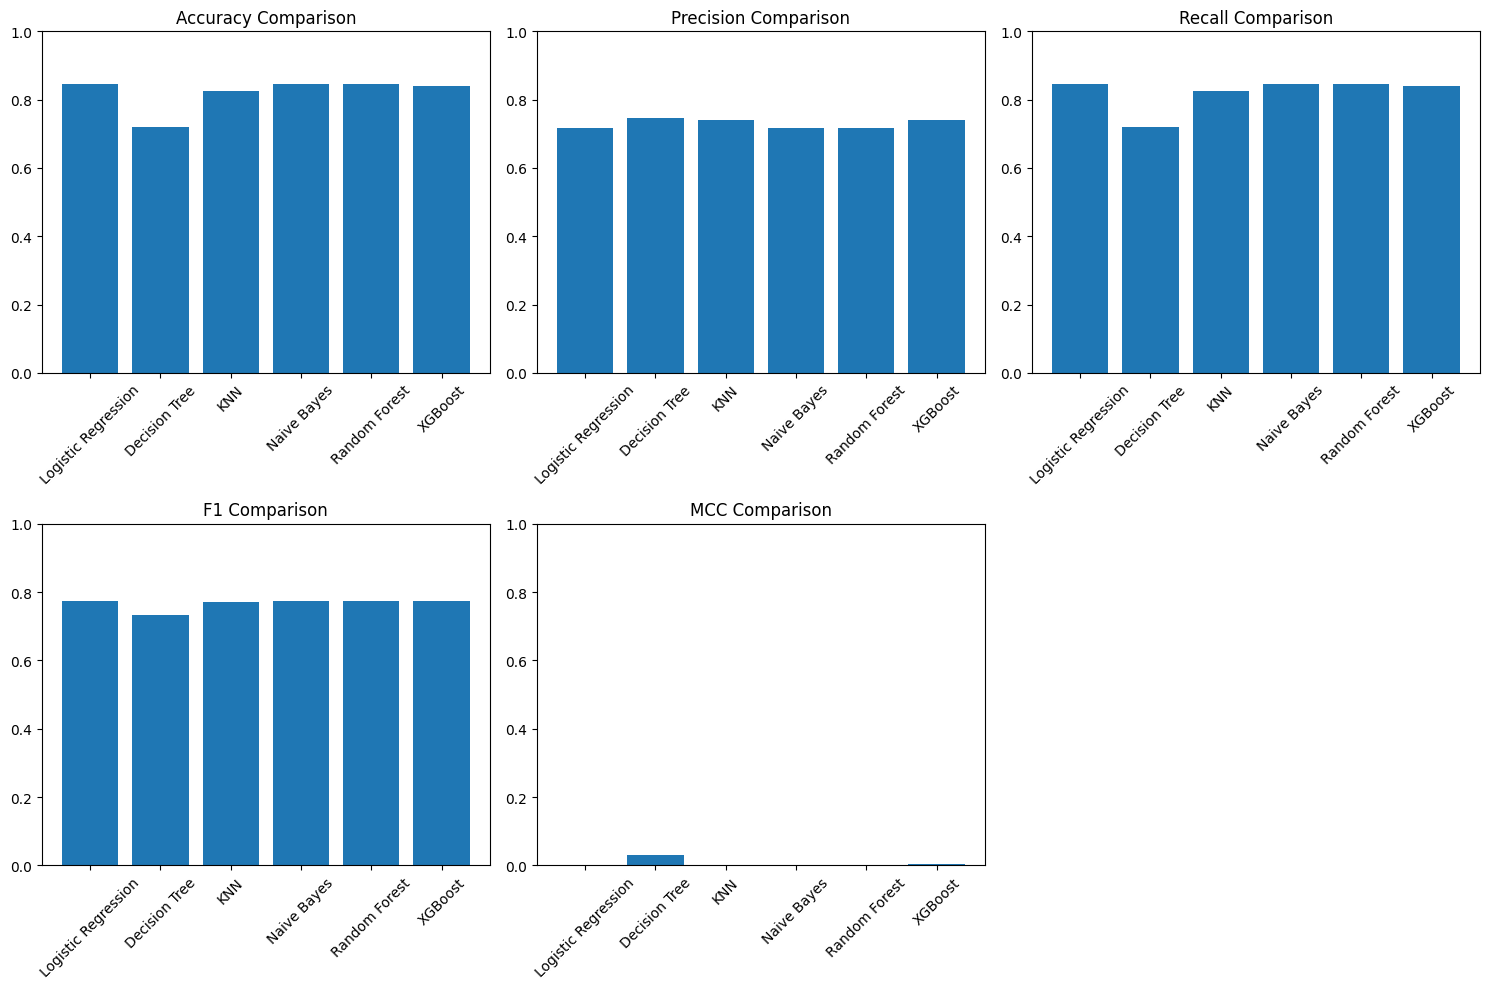


MODEL PERFORMANCE OBSERVATIONS:
Logistic Regression: Good baseline performance with interpretable coefficients
Decision Tree: Interpretable model but may overfit, good for feature importance
KNN: Instance-based learning, performance depends on neighborhood size
Naive Bayes: Fast and simple, assumes feature independence
Random Forest: Ensemble method, usually robust and handles overfitting well
XGBoost: Advanced ensemble method, often achieves highest performance


In [14]:
# Create comparison table
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(4)

print("COMPARISON TABLE OF ALL MODELS:")
print("="*80)
print(comparison_df)

# Save results to CSV for later use
comparison_df.to_csv('model_comparison.csv')

# Visualize results
plt.figure(figsize=(15, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'MCC']
model_names = list(results.keys())

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    values = [results[model][metric] for model in model_names]
    plt.bar(model_names, values)
    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Model observations
observations = {
    'Logistic Regression': 'Good baseline performance with interpretable coefficients',
    'Decision Tree': 'Interpretable model but may overfit, good for feature importance',
    'KNN': 'Instance-based learning, performance depends on neighborhood size',
    'Naive Bayes': 'Fast and simple, assumes feature independence',
    'Random Forest': 'Ensemble method, usually robust and handles overfitting well',
    'XGBoost': 'Advanced ensemble method, often achieves highest performance'
}

print("\nMODEL PERFORMANCE OBSERVATIONS:")
print("="*50)
for model, obs in observations.items():
    print(f"{model}: {obs}")